## Part 1 - Lab Exploration

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Number of nodes: 9877
Number of edges: 25998
Number of connected components: 429
Number of nodes in the largest connected component: 8638
Number of edges in the largest connected component: 24827
Fraction of nodes in the largest connected component: 0.8745570517363572
Fraction of edges in the largest connected component: 0.9549580736979768
Minimum degree: 1
Maximum degree: 65
Median degree: 3.0
Mean degree: 5.264351523742027


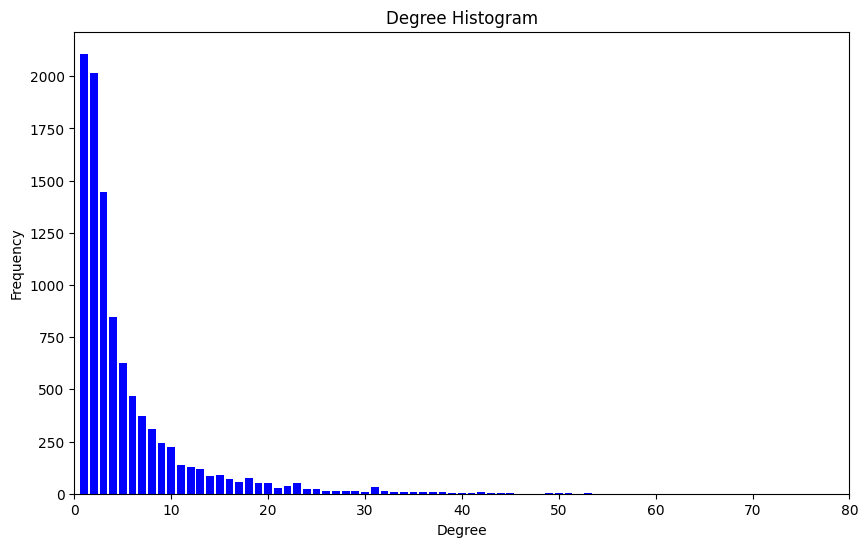

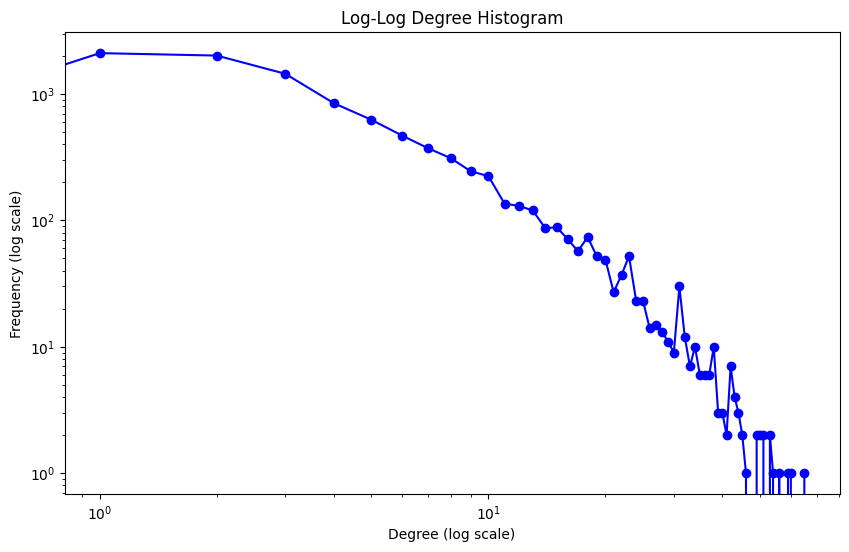

Global Clustering Coefficient (Transitivity) of the graph: 0.2839996525875546


In [2]:
"""
Graph Mining - ALTEGRAD - Oct 2023
"""

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np


############## Task 1

##################
# Load the data into an undirected graph G
# G = nx.read_edgelist('D:\OneDrive\Documents\MVA-ENS-2023-2024\S1\LEARNING\AlteGrad\lab2_graph_mining\code\datasets\CA-HepTh.txt', delimiter='\t', comments='#', create_using=nx.Graph())
G = nx.read_edgelist('/content/drive/MyDrive/MVA-2023-2024/ALTEGRAD/Lab2-Altegrad-MARENGO-Matteo/lab2_graph_mining/code/datasets/CA-HepTh.txt', delimiter='\t', comments='#', create_using=nx.Graph())

# Compute network characteristics
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

# Print the characteristics
print("Number of nodes:", num_nodes)
print("Number of edges:", num_edges)
##################

############## Task 2

##################
# Extract the number of connected components
num_connected_components = nx.number_connected_components(G)
print("Number of connected components:", num_connected_components)

if num_connected_components > 1:
    # Retrieve the largest connected component subgraph
    largest_cc = max(nx.connected_components(G), key=len)
    # Creation of a subgraph of 'G' induced on the nodes present in largest_cc
    largest_subgraph = G.subgraph(largest_cc)

    # Find the number of nodes and edges of the largest connected component
    num_nodes_lcc = largest_subgraph.number_of_nodes()
    num_edges_lcc = largest_subgraph.number_of_edges()

    # Calculate the fraction of nodes and edges of the largest connected component
    node_fraction = num_nodes_lcc / num_nodes
    edge_fraction = num_edges_lcc / num_edges

    print("Number of nodes in the largest connected component:", num_nodes_lcc)
    print("Number of edges in the largest connected component:", num_edges_lcc)
    print("Fraction of nodes in the largest connected component:", node_fraction)
    print("Fraction of edges in the largest connected component:", edge_fraction)
else:
    print("The graph is connected.")
##################

############## Task 3
# Extract the degree_sequence of the graph
degree_sequence = [G.degree(node) for node in G.nodes()]

##################
min_degree = np.min(degree_sequence)
max_degree = np.max(degree_sequence)
median_degree = np.median(degree_sequence)
mean_degree = np.mean(degree_sequence)

print("Minimum degree:", min_degree)
print("Maximum degree:", max_degree)
print("Median degree:", median_degree)
print("Mean degree:", mean_degree)
##################

############## Task 4

##################
degree_hist = nx.degree_histogram(G)
degrees = range(len(degree_hist))

plt.figure(figsize=(10, 6))
plt.bar( degrees,degree_hist, width=0.80, color='b')
plt.title("Degree Histogram")
plt.xlim([0,80])
plt.ylabel("Frequency")
plt.xlabel("Degree")
plt.show()

plt.figure(figsize=(10, 6))
plt.loglog(degrees, degree_hist, 'b-', marker='o')
plt.title("Log-Log Degree Histogram")
plt.ylabel("Frequency (log scale)")
plt.xlabel("Degree (log scale)")
plt.show()
##################

############## Task 5

##################
global_clustering_coefficient = nx.transitivity(G)
print("Global Clustering Coefficient (Transitivity) of the graph:", global_clustering_coefficient)
##################





## Part 2 - Community detection

In [5]:
"""
Graph Mining - ALTEGRAD - Oct 2023
"""

import networkx as nx
import numpy as np
from scipy.sparse.linalg import eigs
from scipy.sparse import diags, eye
from random import randint
from sklearn.cluster import KMeans

############## Task 6
# Perform spectral clustering to partition graph G into k clusters
def spectral_clustering(G, k):

    ##################
    #1 Compute adjacency matrix
    A = nx.adjacency_matrix(G).astype(float)

    #2.1 Compute degree matrix D (as a diagonal matrix)
    degrees = np.array(A.sum(axis=1)).flatten()
    D = diags(degrees)

    #2.2 Compute the normalized Laplacian matrix: Lrw = I - D^(-1)A
    D_inv = diags(1.0 / degrees)
    Lrw = eye(G.number_of_nodes()) - D_inv @ A

    # Compute the k smallest eigenvectors
    _, U = eigs(Lrw, k=k, which='SM') # SM stands for smallest magnitude

    # Use the eigenvectors for k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=randint(1, 100))
    labels = kmeans.fit_predict(U.real)

    # Build the clustering dictionary
    clustering = {node: cluster for node, cluster in zip(G.nodes(), labels)}
    ##################
    return clustering

############## Task 7

##################
# Load the CA-HepTh dataset into a graph
G = nx.read_edgelist('/content/drive/MyDrive/MVA-2023-2024/ALTEGRAD/Lab2-Altegrad-MARENGO-Matteo/lab2_graph_mining/code/datasets/CA-HepTh.txt', delimiter='\t', comments='#', create_using=nx.Graph())

# Extract the largest connected component
largest_cc = max(nx.connected_components(G), key=len)
G_giant = G.subgraph(largest_cc)

# Apply spectral clustering
clusters = spectral_clustering(G_giant, k=50)

# # (Optional) Print the clusters to see the results
# for node, cluster in clusters.items():
#     print(f"Node {node} belongs to cluster {cluster}")

##################

############## Task 8
# Compute modularity value from graph G based on clustering
def modularity(G, clustering):

    ##################
    # Initialize modularity to zero
    modularity = 0.0

    # Compute m (total number of edges in the graph G)
    m = len(G.edges())

    # Get unique communities
    communities = set(clustering.values())

    # Loop over each community to compute intra-community edges and total degree
    for community in communities:
        nodes_in_community = [node for node, comm in clustering.items() if comm == community]

        # Create a subgraph of G consisting of only nodes in the current community
        subgraph = G.subgraph(nodes_in_community)

        # lc is the number of edges in the subgraph
        lc = len(subgraph.edges())

        # dc is the sum of the degrees of nodes in the subgraph
        dc = sum(dict(subgraph.degree()).values())

        # Update the modularity value using the given formula
        modularity += (lc/m) - (dc/(2*m))**2
    ##################

    return modularity

############## Task 9

##################
# 1. Compute modularity for Spectral Clustering result
modularity_spectral = modularity(G_giant, clusters)

print(f"Modularity (Spectral Clustering): {modularity_spectral}")

# 2. Create random clustering
clusters_random = {node: randint(1, 50) for node in G_giant.nodes()}

# 3. Compute modularity for random clustering
modularity_random = modularity(G_giant, clusters_random)

print(f"Modularity (Random Clustering): {modularity_random}")
##################


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Modularity (Spectral Clustering): 0.18105511673791055
Modularity (Random Clustering): 0.020411780799565914


## Part 3 - Graph Classification

In [6]:
"""
Graph Mining - ALTEGRAD - Oct 2023
"""

import networkx as nx
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


############## Task 10
# Generate simple dataset
def create_dataset():
    Gs = list()
    y = list()

    ##################
        # For each size from 3 to 102
    for n in range(3, 103):
        # Generate cycle graph and append to Gs, label as 0 (cycle)
        G_cycle = nx.cycle_graph(n)
        Gs.append(G_cycle)
        y.append(0)

        # Generate path graph and append to Gs, label as 1 (path)
        G_path = nx.path_graph(n)
        Gs.append(G_path)
        y.append(1)
    ##################

    return Gs, y

Gs, y = create_dataset()
G_train, G_test, y_train, y_test = train_test_split(Gs, y, test_size=0.1)

# Compute the shortest path kernel
def shortest_path_kernel(Gs_train, Gs_test):
    all_paths = dict()
    sp_counts_train = dict()

    for i,G in enumerate(Gs_train):
        sp_lengths = dict(nx.shortest_path_length(G))
        sp_counts_train[i] = dict()
        nodes = G.nodes()
        for v1 in nodes:
            for v2 in nodes:
                if v2 in sp_lengths[v1]:
                    length = sp_lengths[v1][v2]
                    if length in sp_counts_train[i]:
                        sp_counts_train[i][length] += 1
                    else:
                        sp_counts_train[i][length] = 1

                    if length not in all_paths:
                        all_paths[length] = len(all_paths)

    sp_counts_test = dict()

    for i,G in enumerate(Gs_test):
        sp_lengths = dict(nx.shortest_path_length(G))
        sp_counts_test[i] = dict()
        nodes = G.nodes()
        for v1 in nodes:
            for v2 in nodes:
                if v2 in sp_lengths[v1]:
                    length = sp_lengths[v1][v2]
                    if length in sp_counts_test[i]:
                        sp_counts_test[i][length] += 1
                    else:
                        sp_counts_test[i][length] = 1

                    if length not in all_paths:
                        all_paths[length] = len(all_paths)

    phi_train = np.zeros((len(Gs_train), len(all_paths)))
    for i in range(len(Gs_train)):
        for length in sp_counts_train[i]:
            phi_train[i,all_paths[length]] = sp_counts_train[i][length]


    phi_test = np.zeros((len(Gs_test), len(all_paths)))
    for i in range(len(Gs_test)):
        for length in sp_counts_test[i]:
            phi_test[i,all_paths[length]] = sp_counts_test[i][length]

    K_train = np.dot(phi_train, phi_train.T)
    K_test = np.dot(phi_test, phi_train.T)

    return K_train, K_test

############## Task 11
# Compute the graphlet kernel
def graphlet_kernel(Gs_train, Gs_test, n_samples=200):
    graphlets = [nx.Graph(), nx.Graph(), nx.Graph(), nx.Graph()]

    graphlets[0].add_nodes_from(range(3))

    graphlets[1].add_nodes_from(range(3))
    graphlets[1].add_edge(0,1)

    graphlets[2].add_nodes_from(range(3))
    graphlets[2].add_edge(0,1)
    graphlets[2].add_edge(1,2)

    graphlets[3].add_nodes_from(range(3))
    graphlets[3].add_edge(0,1)
    graphlets[3].add_edge(1,2)
    graphlets[3].add_edge(0,2)


    phi_train = np.zeros((len(G_train), 4))

    ##################
    # your code here #
    for idx, G in enumerate(Gs_train):
      for _ in range(n_samples):
        nodes_sample = np.random.choice(G.nodes(), 3, replace=False)
        subgraph = G.subgraph(nodes_sample)
        for j, graphlet in enumerate(graphlets):
            if nx.is_isomorphic(subgraph, graphlet):
                phi_train[idx, j] += 1
    ##################

    phi_test = np.zeros((len(G_test), 4))

    ##################
    # your code here #
    for idx, G in enumerate(Gs_test):
      for _ in range(n_samples):
        nodes_sample = np.random.choice(G.nodes(), 3, replace=False)
        subgraph = G.subgraph(nodes_sample)
        for j, graphlet in enumerate(graphlets):
            if nx.is_isomorphic(subgraph, graphlet):
                phi_test[idx, j] += 1
    ##################

    K_train = np.dot(phi_train, phi_train.T)
    K_test = np.dot(phi_test, phi_train.T)

    return K_train, K_test


K_train_sp, K_test_sp = shortest_path_kernel(G_train, G_test)

############## Task 12

##################
# your code here #
K_train_gk, K_test_gk = graphlet_kernel(G_train, G_test,n_samples=200)
##################

############## Task 13

##################
# your code here #
# Train SVM classifiers
svm_sp = SVC(kernel='precomputed').fit(K_train_sp, y_train)
svm_gk = SVC(kernel='precomputed').fit(K_train_gk, y_train)

# Make predictions
y_pred_sp = svm_sp.predict(K_test_sp)
y_pred_gk = svm_gk.predict(K_test_gk)

# Evaluate classifiers
accuracy_sp = accuracy_score(y_test, y_pred_sp)
accuracy_gk = accuracy_score(y_test, y_pred_gk)

print(f"Classification Accuracy (Shortest Path Kernel): {accuracy_sp:.4f}")
print(f"Classification Accuracy (Graphlet Kernel): {accuracy_gk:.4f}")

from sklearn.metrics import confusion_matrix

conf_matrix_sp = confusion_matrix(y_test, y_pred_sp)
conf_matrix_gk = confusion_matrix(y_test, y_pred_gk)
print("Confusion Matrix (Shortest Path Kernel):")
print(conf_matrix_sp)

print("\nConfusion Matrix (Graphlet Kernel):")
print(conf_matrix_gk)

##################





Classification Accuracy (Shortest Path Kernel): 1.0000
Classification Accuracy (Graphlet Kernel): 0.5000
Confusion Matrix (Shortest Path Kernel):
[[ 9  0]
 [ 0 11]]

Confusion Matrix (Graphlet Kernel):
[[ 0  9]
 [ 1 10]]
